In [145]:
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import inspect
import datetime
from scipy.stats import percentileofscore
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import add_preds
from functions import merge_data
from viz import  viz_interactive
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import matplotlib as plt
from scipy.stats import percentileofscore

# CHANGE THIS
from exponential_modeling import *
from fit_and_predict import *

In [43]:
# Load in the Data

print('loading data...')
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))

#df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST,
#                          cached_dir=oj(parentdir, 'data'))

loading data...
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [24]:
currentdir

'/home/ubuntu/new_uploader/modeling'

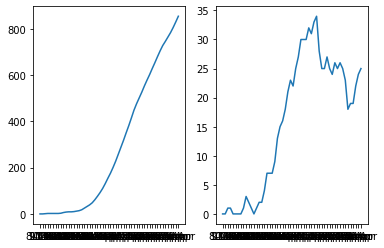

In [153]:
# Currently selecting confirmed cases, can look at probable later
df_ucsf = pd.read_csv("../../covid-19-private-data/ucsf_hospitalization_data.csv", sep="\t")
df_ucsf = df_ucsf[["Date", "ZSFG COVID-19+ (total admitted)"]]
df_ucsf = df_ucsf.rename(columns={"ZSFG COVID-19+ (total admitted)": "hospitalizations"})
df_ucsf['cum_hosp'] = df_ucsf['hospitalizations'].cumsum()
y1 = df_ucsf['cum_hosp']
y2 = df_ucsf['hospitalizations']
x = df_ucsf['Date']
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(x,y1)
ax2.plot(x,y2)

In [157]:
#Now We Fit Linear Model 
df_ucsf_total = df_ucsf[["Date","cum_hosp"]]
df_ucsf_total.head()
linear_fit(df_ucsf_total,'eval_mode',target_day=np.array([1]))

KeyError: 0

In [ ]:
## TODO: Insert Predicted Deaths into DF for UCSF

In [61]:

def fit_and_predict(df, 
                    outcome: str='deaths', 
                    method: str='exponential', 
                    mode: str='predict_future', 
                    target_day: np.ndarray=np.array([1]),
                    output_key: str=None,
                    demographic_vars=[],
                    verbose: bool=False):
    """
    Trains a method (method) to predict a current number of days ahead (target_day)
    Predicts the values of the number of deaths for the final day of test_df and writes to the column
    'predicted_deaths_'+method+'_'+str(target_day[-1]) of the test_df
    
    Params
    ------
    df
        a df with county level deaths and cases and demographic information
    outcome
        key for the outcome to predict (the values in this column should have a list for each row)
    method
        what method to use to do forecasting
    target_day
        np.array([1,2,..,n]) predicts these number of days ahead (can just be np.array([3])) for example if you just want 3 days ahead)
    output_key
        key to save the output as
    mode:
        either 'predict_future' or 'eval_mode'
        predict_future is predicting deaths on FUTURE days, so target_day=np.array([1])) means it predicts tomorrow's deaths
        eval_mode is for evaluating the performance of the classifier. 
        target_day=np.array([k])) will predict the current days death count using information from k days ago. 
        target_day= np.array([1,2,3,...,k]) will predict todays deaths, yesterdays deaths, deaths k-1 days ago using information from k days ago.
    Returns
    -------
    test_df
        returns dataframe with added column
    """
    assert mode == 'predict_future' or mode == 'eval_mode', 'unknown mode'
    if output_key is None:
        output_key = f'predicted_{outcome}_{method}_{target_day[-1]}'
        if len(demographic_vars) > 0:
            output_key += '_demographics'
    if method == 'AR':
        print('currently deprecated')
        raise NotImplementedError
        loss, model, best_window = naive_autoreg_baselines.train_and_evaluate_model(train_df,test_df)
        return naive_autoreg_baselines.make_predictions(test_df,model,best_window)
    
    elif method == 'exponential':
        preds = exponential_modeling.exponential_fit(df[outcome].values, 
                                                     mode=mode, 
                                                     target_day=target_day)
        
            
        df[output_key] = preds
        #del test_df['predicted_deaths_exponential']

        return df
    
    elif method == 'linear':
        preds = exponential_modeling.linear_fit(df[outcome].values, 
                                                     mode=mode, 
                                                     target_day=target_day)
        
            
        df[output_key] = preds
        #del test_df['predicted_deaths_exponential']

        return df        
    
    elif method == 'shared_exponential':
        # Fit a poisson GLM with shared parameters across counties. Input to the poisson GLM is demographic_vars and log(previous_days_deaths+1)
        cur_day_predictions = exponential_modeling.fit_and_predict_shared_exponential(df,mode,outcome=outcome,demographic_vars=demographic_vars,target_day=target_day, verbose=verbose)
        #if len(demographic_vars) > 0:
        #    output_key += '_demographics'
        # import IPython
        # IPython.embed()
        df[output_key] = cur_day_predictions
        return df
    
    elif method == 'ensemble':
        print('please use fit_and_predict_ensemble instead')

    elif method == 'advanced_shared_model':
        

    
    
    



        feat_transforms = defaultdict(lambda y: [lambda x: x]) 
        feat_transforms['deaths_per_cap'] = [lambda x: np.log(x+1)]
        feat_transforms['deaths'] = [lambda x: np.log(x+1)]
        feat_transforms['new_deaths'] = [lambda x: np.log(x+1)]
        feat_transforms['cases'] =  [lambda x: np.log(x+1)]
        feat_transforms['neighbor_deaths'] =  [lambda x: np.log(x+1)]
        feat_transforms['neighbor_cases'] =  [lambda x: np.log(x+1)]
        default_values = defaultdict(lambda: 0) 
        aux_feats = ['cases','neighbor_deaths','neighbor_cases']
        shared_model = SharedModel(df=df,outcome=outcome,demographic_variables=[],mode=mode,target_days=target_day, feat_transforms=feat_transforms,auxiliary_time_features=aux_feats,time_series_default_values=default_values,scale=True)
        shared_model.create_dataset()
        shared_model.fit_model()
        shared_model.predict()

        df[output_key] = shared_model.predictions
        return df

        
        
    else:
        print('Unknown method')
        raise ValueError

def fit_and_predict_ensemble(df, 
                             target_day: np.ndarray=np.array([1]),
                             outcome: str='deaths', 
                             methods: list=[shared_exponential, linear],
                             mode: str='predict_future', 
                             output_key: str=None,
                             verbose: bool=False):
    
    """
    Function for ensemble prediction
    Input:
        df: pd.DataFrame
        target_day: array
        outcome: str 
        method: list of dictionary
            each dictionary specify the type and parameters of the model
        mode: str
        output_key: str
    Output:
        df with ensemble prediction
    """
    if output_key is None:
        output_key = f'predicted_{outcome}_ensemble_{target_day[-1]}'
    predictions = {}
    
    for (i, model) in enumerate(methods):
        if 'demographic_vars' in model:
            demographic_vars = model['demographic_vars']
        else:
            demographic_vars = []
            
        predictions[i] = fit_and_predict(df, 
                                         outcome=outcome, 
                                         method=model['model_type'], 
                                         mode=mode, 
                                         target_day=target_day,
                                         output_key=f'y_preds_{i}',
                                         demographic_vars=demographic_vars,
                                         verbose=verbose)[f'y_preds_{i}'].values
            
    if mode == 'predict_future':
        use_df = df
    else:
        use_df = exponential_modeling.leave_t_day_out(df, target_day[-1])
            
    
    weights = pmdl_weight.compute_pmdl_weight(use_df, 
                                              methods=methods, 
                                              outcome=outcome,
                                              target_day=target_day)
    sum_weights = np.zeros(len(use_df))
    for model_index in weights:
        sum_weights = sum_weights + np.array(weights[model_index])
    
    #weighted_preds = np.zeros((len(use_df), len(target_day)))
    weighted_preds = [np.zeros(len(target_day)) for i in range(len(use_df))]
    for i in range(len(df)):
        for model_index in weights:
            weighted_preds[i] += np.array(predictions[model_index][i]) * weights[model_index][i] / sum_weights[i]

    # print out the relative contribution of each model
    if verbose:
        print('--- Model Contributions ---')
        model_weight_counter = Counter()
        for model_index in weights:
            m_weights = 0
            for i in range(len(use_df)):
                m_weights += weights[model_index][i] / sum_weights[i]
            m_weights = m_weights/len(use_df)
            model_weight_counter[model_index] = m_weights
        for model_index, weight in model_weight_counter.most_common():
            print(str(methods[model_index])+': '+str(weight))

    df[output_key] = weighted_preds
    return df

In [ ]:
def exponential_fit(counts, mode, target_day=np.array([1])): 
    # let target_day=np.array([5]) to predict 5 days in advance, 
    # and target_day=np.array([1, 2, 3, 4, 5]) to generate predictions for 1-5 days in advance 
    
    """
    Parameters:
        counts: array
            each row is the cases/deaths of one county over time
        target_day: array
            for each element {d} in the array, will predict cases/deaths {d} days from the last day in {counts}
    Return:
        array
        predicted cases/deaths for all county, for each day in target_day
    """
    predicted_counts = []
    for i in range(len(counts)):
        if mode == 'eval_mode':
            # Only use days up to from target[-1] for training. So if target[-1] = 1, only use the days before today for training and predict on today's data
            num_days_back = target_day[-1]
            train_ts = counts[i][:-num_days_back]
        elif mode == 'predict_future':
            # Use all days
            train_ts = counts[i]
        else:
            print('Unknown mode')
            raise ValueError 

        # if train_ts[-1] > 100:
        #     start = np.where(train_ts >= 10)[0][0]
        
        # elif train_ts[-1] >= 1:
        #     start = np.where(train_ts == 0)[0][-1] + 1
        # else:
        #     start = len(train_ts)
        # active_day = len(train_ts) - start # days since 'outbreak'


        # # active_day =5
        # # start = len(train_ts)-active_day 
        # if active_day > 5:
        #     active_day = 5
        #     start = len(train_ts) - active_day

        if train_ts[-1] >= 1:
             start = np.where(train_ts == 0)[0][-1] + 1
        else:
             start = len(train_ts)
        active_day = len(train_ts) - start # days since 'outbreak'
        if active_day > 5:
            active_day = 5 
        start = len(train_ts) - active_day
        
        if active_day <=2 or min(train_ts[start:]) == max(train_ts[start:]):
            # corner case 1: cases remain constant, unable to fit Poisson glm
            # solution: use previous day cases to predict
            predicted_counts.append(np.array([train_ts[-1]]*len(target_day)))
        #if active_day >= 3 and train_ts[-1] > 4:
        elif min(train_ts[start:]) > 0 and min(np.diff(np.log(train_ts[start:]))) == max(np.diff(np.log(train_ts[start:]))):
            # corner case 2: cases follow perfect exponential growth, unable to fit Poisson glm
            # solution: use cosntant growth rate to predict
            rate = 1.0 * train_ts[-1]/train_ts[-2]
            predicted_counts.append(np.array(train_ts[-1]*np.array([rate**i for i in target_day])))   
        else:
            # fit Poisson glm
            X_train = np.transpose(np.vstack((np.array(range(active_day)), 
                                              #np.log(np.array(range(active_day))+1),
                                              np.ones(active_day))))
            m = sm.GLM(train_ts[start:], 
                       X_train,
                       family=sm.families.Poisson(),
                       #family=sm.families.NegativeBinomial(alpha=.05),
                       freq_weights=np.array([1 ** i for i in range(active_day)])[::-1])
            try:
                m =  m.fit()
                X_test = np.transpose(np.vstack((target_day + active_day - 1, 
                                             #np.log(target_day + active_day),
                                             np.ones(len(target_day)))))
                predicted_counts.append(np.array(m.predict(X_test)))
            except PerfectSeparationError as e:
                print('Warning: PerfectSeparationError detected')
                rate = 1.0 * train_ts[-1]/train_ts[-2]
                predicted_counts.append(np.array(train_ts[-1]*np.array([rate**i for i in target_day])))  
                #X_train[-1][0] += 1
                #m = sm.GLM(train_ts[start:], 
                #X_train,
                #family=sm.families.Poisson(),
                #family=sm.families.NegativeBinomial(alpha=.05),
                #freq_weights=np.array([1 ** i for i in range(active_day)])[::-1])
                #m =  m.fit()

        #else:
        #    predicted_counts.append(np.array([train_ts[-1]]*len(target_day)))
            ## if there are too few data points to fit a curve, return the cases/deaths of current day as predictions for future

                
    return predicted_counts 


In [112]:
fit_and_predict_ensemble(df_ucsf, outcome="hospitalizations")

KeyError: 'hospitalizations'